In [45]:
import math
import random
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.image as mpimg
%matplotlib inline

# Canny Edge Detection

From Wikipedia:  

The process of Canny edge detection algorithm can be broken down to 5 different steps:

1. Apply Gaussian filter to smooth the image in order to remove the noise
2. Find the intensity gradients of the image
3. Apply non-maximum suppression to get rid of spurious response to edge detection
4. Apply double threshold to determine potential edges
5. Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.

## Gaussian filter

### 1D Implementation

The value $G(x)$ of a one-dimensional Gaussian distrubitionmay be given as

$$
G(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\bigg({-\frac{x^2}{2\sigma^2}}\bigg)
$$

where $\mu$ is the average (i.e. centre) and $\sigma$ is the standard deviation. Codifying the above gives

In [5]:
def getGauss(x, mu, sigma):
    '''Generates G(x) of a Gaussian function of 
    average mu and standard deviation sigma
    '''
    coeff1 = 1 / math.sqrt(2 * math.pi * sigma**2)
    coeff2 = math.exp(-(x**2) / (2 * sigma**2))
    return coeff1 * coeff2

We may use `getGauss()` to plot $G(x)$ over a range of values to gain a basic idea of its shape

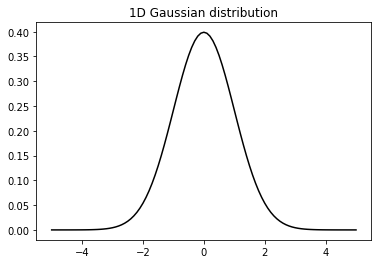

In [6]:
dx = 10
domain = [i / dx for i in range(-50, 50+1)]
y = [getGauss(x, 0, 1) for x in domain]
plt.plot(domain, y, color='k')
plt.title('1D Gaussian distribution')
plt.show()

A kernel works essentially like a "stamp" of weighted averages – it changes the value of a data point to a weighted average of itself and its neighbours. The amount of neighbours taken into the average dependents on the size of the kernel. The larger the kernel, the more neighbours are considered.

Therefore, we may use the Gaussian distribution as the basis of a kernel for smoothing data (and eventually, images!). Like the curve above, the weight is highest at the center and diminishes as we move away. The technical term for applying a kernel upon a data point is known as a __convolution__. That is to say, we convolute the data and the kernel to reach our desired result. 

That said, we can use `getGauss()` defined above to generate our kernel. For this instance, we create a kernel of size 5.

In [7]:
size = 5
gaussian_kernel = [getGauss(i - size//2, 0, 1) for i in range(size)]
print('Gaussian Kernel:')
print(gaussian_kernel)

Gaussian Kernel:
[0.05399096651318806, 0.24197072451914337, 0.3989422804014327, 0.24197072451914337, 0.05399096651318806]


Note how the kernel is a discrete representation of the continuous Gaussian curve above. 

Now, we apply the kernel to the data by convoluting the kernel with each data point. Note that if the kernel does not fit fully (e.g. on the edges), we disregard those values. For example consider `data = [1, 2, 3, 4, 5]`. Applying our Gaussian kernel on the first element, we only consider the values `data[0]`, `data[1]` and `data[2]`.

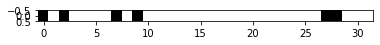

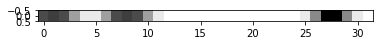

In [25]:
def convolute(data, kernel, x):
    '''Performs convolution between data[x] and kernel'''
    length = len(data)
    n = len(kernel)
    total = 0
    for i in range(n):
        dx = i - n//2
        idx = (x + dx)
        if 0 <= idx < length:
            total += data[idx] * kernel[i]
    return total

def apply_kernel(data, kernel):
    '''Applies kernel to every point in data'''
    result = [convolute(data, kernel, i) for i in range(len(data))]
    return result

def apply_kernel_sp(data, kernel):
    result = np.convolve(data, kernel, mode='same')
    return result


# Driver code
size = 32
data_raw = [0 if random.uniform(0,1) < 0.8 else 1 for _ in range(size)]
data_smoothed = apply_kernel_sp(data_raw, gaussian_kernel)

n = len(data_raw)
#plt.bar(list(range(n)), data_raw)
#plt.bar(list(range(n)), data_smoothed)
plt.imshow([data_raw], cmap = 'binary')
plt.show()
plt.imshow([data_smoothed], cmap = 'binary')
#plt.legend(['Raw Data', 'Gaussian Kernel'])
plt.show()

### 2D Implementation

Similar to the 1D function, the value $G(x, y)$ of a two-dimensional Gaussian distrubition with average $\mu$ and standard deviation $\sigma$ may be given as

$$
G(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\bigg({-\frac{x^2 + y^2}{2\sigma^2}}\bigg)
$$

In code, we have

In [30]:
def getGauss2D(x, y, mu, sigma):
    '''Generates G(x, y) of a Gaussian function of 
    average mu and standard deviation sigma
    '''
    coeff1 = 1 / math.sqrt(2 * math.pi * sigma**2)
    coeff2 = math.exp(-(x**2 + y**2) / (2 * sigma**2))
    return coeff1 * coeff2

Following the same process previously, we can visualise the $G(x, y)$ using a surface plot. We also use the `numpy` module to make meshgrids a little easier.

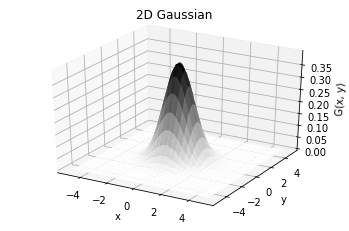

In [31]:
dx, dy = 10, 10
domainX = [i/dx for i in range(-5*dx, 5*dx+1)]
domainY = [j/dx for j in range(-5*dy, 5*dy+1)]
Z = [[getGauss2D(x, y, 0, 1) for x in domainX] for y in domainY]

# Non-numpy meshgrid
# X = [domainX] * len(domainY)
# Y = [[i]*len(domainX) for i in domainY]

X, Y = np.meshgrid(domainX, domainY)

fig = plt.figure()
ax = plt.axes(projection='3d')
plt.title('2D Gaussian')
ax.plot_surface(X, Y, np.array(Z), cmap = 'binary', edgecolor = 'none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('G(x, y)')
ax.dist = 10.5 # Zoom out a bit to prevend axis label being cropped
plt.show()

In [56]:
def generate_gaussian_kernel2D(mu = 0, sigma = 1, size = 5):
    return [[getGauss2D(x-size//2, y-size//2, mu, sigma) for x in range(size)] for y in range(size)]

gaussian_kernel2D = generate_gaussian_kernel2D()
print('2D Gaussian Kernel:')
for j in range(5):
    for i in range(5):
        print('{:.3f}'.format(gaussian_kernel2D[j][i]), end = ' ')
    print()

2D Gaussian Kernel:
0.007 0.033 0.054 0.033 0.007 
0.033 0.147 0.242 0.147 0.033 
0.054 0.242 0.399 0.242 0.054 
0.033 0.147 0.242 0.147 0.033 
0.007 0.033 0.054 0.033 0.007 


In [52]:
def convolute2D(data, kernel, x, y):
    '''Performs convolution between data[y][x] and kernel'''
    height, width = len(data), len(data[0])
    m, n = len(kernel), len(kernel[0])
    total = 0
    for i in range(n):
        for j in range(m):
            dx, dy = i - n//2, j - m//2
            X, Y = (x + dx), (y + dy)
            if 0 <= X < width and 0 <= Y < height:
                total += data[Y][X] * kernel[j][i]
    return total

def apply_kernel2D(data, kernel):
    '''Applies kernel to every point in data'''
    result = [[convolute2D(data, kernel, i, j) for i in range(len(data[0]))] for j in range(len(data))]
    return result

def apply_kernel2D_sp(data, kernel):
    result = signal.convolve(data, kernel, mode='same')
    return result

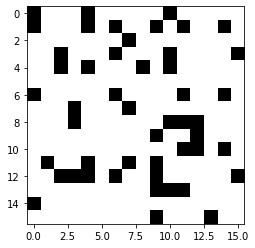

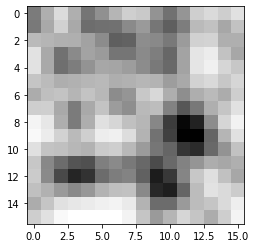

In [55]:
size = 16
raw_data = [[None for _ in range(size)] for _ in range(size)]
for i in range(size):
    for j in range(size):
        raw_data[i][j] = 0 if random.uniform(0, 1) < 0.8 else 1
        
smoothed_data = apply_kernel2D_sp(raw_data, gaussian_kernel2D)

plt.imshow(raw_data, cmap = 'binary')
plt.show()
plt.imshow(smoothed_data, cmap = 'binary')
plt.show()

## Finding intensity gradients

### Sobel operator

$$
{G}_x = 
\begin{bmatrix}
+1 & 0 & -1 \\
+2 & 0 & -2 \\
+1 & 0 & -1
\end{bmatrix} 
\;\;
{G}_y = 
\begin{bmatrix}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{bmatrix} 
\;\;\;
\text{where } G_x \equiv G_y^{\text{T}}
$$

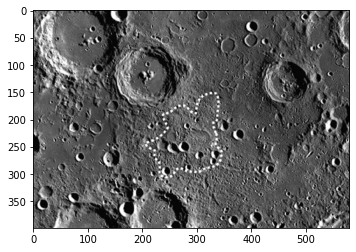

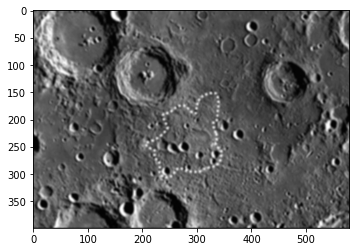

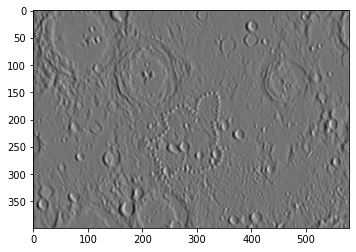

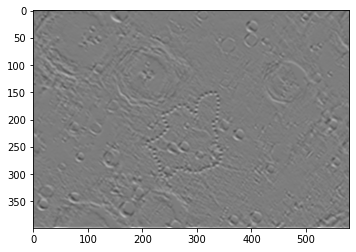

In [64]:
sobelX_kernel2D = [[1, 0, -1], 
                   [2, 0, -2],
                   [1, 0, -1]]

sobelY_kernel2D = [[ 1,  2,  1], 
                   [ 0,  0,  0],
                   [-1, -2, -1]]

original = mpimg.imread('./images/moon.png')
# Convert to grayscale
original = np.dot(original[...,:3], [0.2989, 0.5870, 0.1140]) 
plt.imshow(original, cmap='gray')
plt.show()
mpimg.imsave('./images/results/step0.png', original, cmap='gray')

original = apply_kernel2D(original, generate_gaussian_kernel2D(0, 2, 5))
plt.imshow(original, cmap='gray')
plt.show()
mpimg.imsave('./images/results/step1.png', original, cmap='gray')

sobel_x = apply_kernel2D(original, sobelX_kernel2D)
plt.imshow(sobel_x, cmap='gray')
plt.show()

sobel_y = apply_kernel2D(original, sobelY_kernel2D)
plt.imshow(sobel_y, cmap='gray')
plt.show()

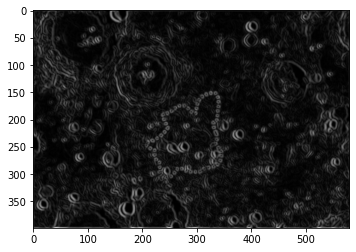

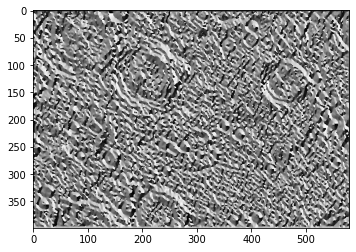

In [65]:
def combine_sobel(sobel_x, sobel_y):
    G_x, G_y = np.array(sobel_x), np.array(sobel_y)
    G = np.sqrt(G_x**2 + G_y**2)
    theta = np.arctan2(G_y, G_x) * (180 / math.pi)
    return G, theta
        
G1, theta = combine_sobel(sobel_x, sobel_y)
# G1 = G1 / G1.max() * 255

plt.imshow(G1, cmap='gray')
plt.show()
mpimg.imsave('./images/results/step2.png', G1, cmap='gray')

plt.imshow(theta, cmap='gray')
plt.show()

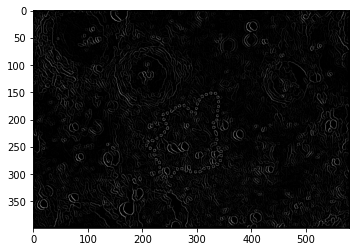

In [66]:
def non_maximum_suppression(G, theta):
    '''Assumes theta is already rounded to 45degs'''
    m, n = G.shape
    result = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            try:
                direction = theta[i][j]
                if direction == 0 or direction == 180 or direction == -180 :
                    nbr1 = G[i][j-1]
                    nbr2 = G[i][j+1]
                elif direction == 45 or direction == -135:
                    nbr1 = G[i-1][j-1]
                    nbr2 = G[i+1][j+1]
                elif direction == 90 or direction == -90:
                    nbr1 = G[i-1][j]
                    nbr2 = G[i+1][j]
                elif direction == 135 or direction == -45:
                    nbr1 = G[i-1][j+1] # G[i+1][j+1] ??
                    nbr2 = G[i+1][j-1]
                
                if G[i][j] > nbr1 and G[i][j] > nbr2:
                    result[i][j] = G[i][j]
                else:
                    result[i][j] = 0
                    
            except IndexError as e:
                pass
    return result

# Round to nearest 45 degree angle
round_to = 45
theta = (theta + round_to / 2) // round_to * round_to

G2 = non_maximum_suppression(G1, theta)
plt.imshow(G2, cmap='gray')
plt.show()
mpimg.imsave('./images/results/step3.png', G2, cmap='gray')

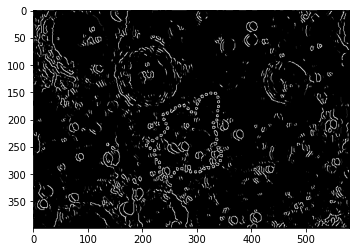

In [71]:
def threshold(img, low_ratio = 0.05, high_ratio = 0.10):
    '''High-low thresholding'''
    high = img.max() * high_ratio
    low = high * low_ratio # Understand
    
    m, n = img.shape
    res = np.zeros((m, n))
    
    strong = 255
    weak = 50
    
    strongs = set()
    weaks = []
    
    for i in range(m):
        for j in range(n):
            if img[i][j] > high:
                strongs.add((i, j))
                res[i][j] = strong
            elif low < img[i][j] <= high:
                weaks.append((i, j))
                res[i][j] = weak

    return res, strongs, weaks
    
    
# G3, weak, strong = threshold(G2)
G3, strongs, weaks = threshold(G2, 0.8, 0.19)

plt.imshow(G3, cmap='gray')
plt.show()
mpimg.imsave('./images/results/step4.png', G3, cmap='gray')

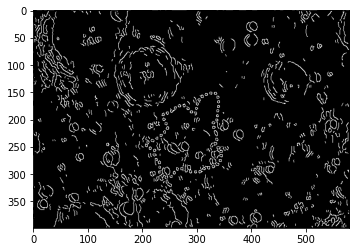

In [72]:
def hysteresis(img, weaks, strongs):
    m, n = img.shape
    res = np.zeros((m, n))
    
    strong = img.max()
    for i, j in strongs:
        res[i][j] = strong
    
    # First pass downwards
    for i, j in weaks:
        nbrs = [(i, j+1), (i+1, j+1), (i+1, j), (i+1, j-1), 
                (i, j-1), (i-1, j-1), (i-1, j), (i-1, j+1)]
        for nbr in nbrs:
            if nbr in strongs:
                res[i][j] = strong
                strongs.add((i, j))
                break
                
    # Second pass upwards
    for i, j in reversed(weaks):
        nbrs = [(i, j+1), (i+1, j+1), (i+1, j), (i+1, j-1), 
                (i, j-1), (i-1, j-1), (i-1, j), (i-1, j+1)]
        for nbr in nbrs:
            if nbr in strongs:
                res[i][j] = strong
                strongs.add((i, j))
                break
                
    return res

G4 = hysteresis(G3, weaks, strongs)
plt.imshow(G4, cmap='gray')
plt.show()
mpimg.imsave('./images/results/step5.png', G4, cmap='gray')